In [1]:
from myconfig import *
from utils import *

import pandas as pd
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

/Users/tniyomkarn/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# Create label

In [2]:
df = pd.read_pickle(output + '/df.pkl')

In [3]:
df_1 = check_y(df, delta_change=-2.0, start = 1500, end = 1800) 

/Users/tniyomkarn/KKU_med/ml-med/utils.py:151: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/tniyomkarn/KKU_med/ml-med/utils.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/tniyomkarn/KKU_med/ml-med/utils.py:153: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/tniyomkarn/KKU_med/ml-med/utils.p

Already created target(y)


In [4]:
data_2, features = create_features(df_1, n_before = 3)

Already created moving average features -------------------------------------------------------
Already created avg and sd of features at 0 secs before 
Already created avg and sd of features at 600 secs before 
Already created avg and sd of features at 1200 secs before 


In [5]:
data_2 = data_2[data_2['SpO2'].isnull() == False]

In [6]:
print(data_2.groupby(['y_flag']).size())

y_flag
0    295986
1      6896
dtype: int64


In [7]:
f = features.copy()
f.extend(['dataset_datetime', 'dataset_location', 'SpO2', 'Respiratory Rate', 'Mean Airway Pressure', 'Inspired Tidal Volume', 'y_flag', 'y_value'])
print(f)
data_2[data_2['dataset_location']  == 'MICU2-6FL-B2'][f].to_csv('/Users/tniyomkarn/KKU_med/data/check_value.csv')

['Respiratory Rate_moving_mean_avg', 'Mean Airway Pressure_moving_mean_avg', 'Inspired Tidal Volume_moving_mean_avg', 'SpO2_moving_mean_avg', 'Respiratory Rate_moving_sd_avg', 'Mean Airway Pressure_moving_sd_avg', 'Inspired Tidal Volume_moving_sd_avg', 'SpO2_moving_sd_avg', 'Respiratory Rate_mean0s', 'Mean Airway Pressure_mean0s', 'Inspired Tidal Volume_mean0s', 'SpO2_mean0s', 'Respiratory Rate_std0s', 'Mean Airway Pressure_std0s', 'Inspired Tidal Volume_std0s', 'SpO2_std0s', 'Respiratory Rate_mean600s', 'Mean Airway Pressure_mean600s', 'Inspired Tidal Volume_mean600s', 'SpO2_mean600s', 'Respiratory Rate_std600s', 'Mean Airway Pressure_std600s', 'Inspired Tidal Volume_std600s', 'SpO2_std600s', 'Respiratory Rate_mean1200s', 'Mean Airway Pressure_mean1200s', 'Inspired Tidal Volume_mean1200s', 'SpO2_mean1200s', 'Respiratory Rate_std1200s', 'Mean Airway Pressure_std1200s', 'Inspired Tidal Volume_std1200s', 'SpO2_std1200s', 'dataset_datetime', 'dataset_location', 'SpO2', 'Respiratory Rate',

In [8]:
location = 'MICU2-6FL-B1'
df_locat = data_2[data_2['dataset_location'] == location].copy()
df_locat['y_value_1'] = np.where(df_locat['y_value'] == 1, df_locat['SpO2'], float('nan') )
df_locat['y_value_2'] = np.where(df_locat['y_cut_flag'] == 'cut', df_locat['SpO2'], float('nan') )

traces = []

for i, col in enumerate(['SpO2', 'SpO2_moving_mean_avg', 'SpO2_mean0s', 'SpO2_mean600s']):
    traces.append(go.Scatter(
                    x = df_locat.dataset_datetime,
                    y = df_locat[col],
                    mode = 'lines',
                    name = col
                    ))
    
traces.append(go.Scatter(
            x = df_locat.dataset_datetime,
            y = df_locat.y_value_1,
            mode = 'markers',
            marker = dict(color = 'rgb(255,0,0)'),
            name = "'y'"
            ))
traces.append(go.Scatter(
            x = df_locat.dataset_datetime,
            y = df_locat.y_value_2,
            mode = 'markers',
            marker = dict(color = 'rgb(0,0,255)'),
            name = "'y'"
            ))



fig = go.Figure(data = traces) # , layout = layout
plot(fig, filename = location + '.html')

'file:///Users/tniyomkarn/KKU_med/ml-med/MICU2-6FL-B1.html'

# Model

In [9]:
x_data = data_2[features].as_matrix()
y_data = data_2['y_flag'].as_matrix()
#x_train, y_train, x_test, y_test = split_data(x_data, y_data)

In [10]:
n_split = 1
test_size = 0.25
seed = 42
sss = StratifiedShuffleSplit(n_splits = n_split, test_size = test_size, random_state = seed)
print(sss)
x_train = []
y_train = []
x_test = []
y_test = []
for train_index, test_index in sss.split(x_data, y_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train1, x_test1 = x_data[train_index], x_data[test_index]
    y_train1, y_test1 = y_data[train_index], y_data[test_index]
    
    x_train.append(x_train1)
    y_train.append(y_train1)
    x_test.append(x_test1)
    y_test.append(y_test1)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.25,
            train_size=None)
TRAIN: [177953 221810 275544 ..., 140828 249331  17238] TEST: [118086 106640  17640 ..., 182243 269815  33460]


In [11]:
def under_sampling(labels, p):
    negative_idx = np.random.choice(np.where(labels == 0)[0], size=int(len(labels)*p), replace=False)
    positive_idx = np.where(labels==1)[0]
    return np.concatenate([negative_idx, positive_idx])

In [12]:
x_train = x_train[0]
y_train = y_train[0]
x_test = x_test[0]
y_test = y_test[0]

resampled_idx = under_sampling(y_train, 0.2)
x_resampled, y_resampled = x_train[resampled_idx], y_train[resampled_idx]

#sm = SMOTE(random_state = seed, ratio = 0.5)  # class ratio of 1
#x_resamp, y_resamp = sm.fit_sample(x_resampled, y_resampled)
#print(y_train.value_counts(), np.bincount(y_resamp))

In [13]:
print(len(x_resampled))
print(len(y_resampled))

50604
50604


In [14]:
# Algorithm gradient boosting
eval_set = [(x_test, y_test)]
clf = XGBClassifier()
clf.fit(x_resampled, y_resampled, early_stopping_rounds = 10, eval_metric = ["auc"], eval_set = eval_set, verbose = True)
print(clf)

y_pred = clf.predict(x_test)
prediction = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, prediction)
print("Accuracy: %.2f%%" %(accuracy * 100.0))

results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss
"""import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()"""



[0]	validation_0-auc:0.656259
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698439
[2]	validation_0-auc:0.700407
[3]	validation_0-auc:0.722498
[4]	validation_0-auc:0.724226
[5]	validation_0-auc:0.782675
[6]	validation_0-auc:0.786291
[7]	validation_0-auc:0.78647
[8]	validation_0-auc:0.800331
[9]	validation_0-auc:0.809493
[10]	validation_0-auc:0.810493
[11]	validation_0-auc:0.815709
[12]	validation_0-auc:0.820304
[13]	validation_0-auc:0.82555
[14]	validation_0-auc:0.82277
[15]	validation_0-auc:0.823102
[16]	validation_0-auc:0.828144
[17]	validation_0-auc:0.831995
[18]	validation_0-auc:0.832773
[19]	validation_0-auc:0.831878
[20]	validation_0-auc:0.83368
[21]	validation_0-auc:0.837379
[22]	validation_0-auc:0.836338
[23]	validation_0-auc:0.839023
[24]	validation_0-auc:0.841425
[25]	validation_0-auc:0.841209
[26]	validation_0-auc:0.843721
[27]	validation_0-auc:0.844829
[28]	validation_0-auc:0.846293
[29]	validation_0-auc:0.84715
[30]	validation_0-auc

"import matplotlib.pyplot as pyplot\nfig, ax = pyplot.subplots()\nax.plot(x_axis, results['validation_0']['auc'], label='Train')\nax.plot(x_axis, results['validation_1']['auc'], label='Test')\nax.legend()\npyplot.ylabel('AUC')\npyplot.title('XGBoost AUC')\npyplot.show()"

In [15]:
import matplotlib.pyplot as pyplot
pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
pyplot.show()

In [16]:
feature_imp = pd.DataFrame({"imp": clf.feature_importances_,"col": features})

In [17]:
feature_imp.sort_values("imp", ascending=False)

,col,imp
10,Inspired Tidal Volume_mean0s,0.088191
25,Mean Airway Pressure_mean1200s,0.065770
26,Inspired Tidal Volume_mean1200s,0.053812
20,Respiratory Rate_std600s,0.044843
23,SpO2_std600s,0.043348
31,SpO2_std1200s,0.043348
29,Mean Airway Pressure_std1200s,0.043348
27,SpO2_mean1200s,0.041854
13,Mean Airway Pressure_std0s,0.038864
7,SpO2_moving_sd_avg,0.037369


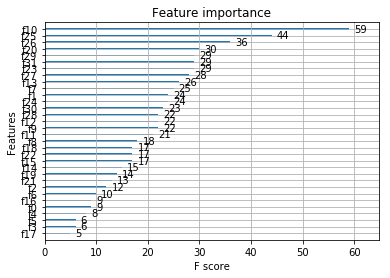

In [18]:
from xgboost import plot_importance
plot_importance(clf)
pyplot.show()

In [19]:
# pickle.dump(clf, open("xgb.pickle.dat", "wb"))

In [20]:
# load
# loaded_model = pickle.load(open("pima.pickle.dat", "rb"))